In [2]:
using SeisNoise, SeisBase, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics, ImageFiltering, FFTW, JLD2, Dates
import SeisNoise: NoiseData 
import SeisBase: read_nodal, NodalData, InstrumentPosition, InstrumentResponse, show_str, show_t, show_x, show_os
import FFTW: rfft, irfft
import DSP: hilbert
import Images: findlocalmaxima
import Base:show, size, summary
import PyCall
import SeisDvv
import Dates
import FiniteDifferences
import CSV
using NetCDF
using DataFrames
include("../correlation/functions/Types.jl")
include("../correlation/functions/Nodal.jl")
include("../correlation/functions/Misc.jl")
include("../correlation/functions/Workflow.jl")

workflow (generic function with 3 methods)

In [8]:
"

Set postprocessing parameters

"

# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
files_1khz = glob("1kHz/*",path)
N = read_nodal("segy", files_1khz[2])

# processing parameters
freqmin, freqmax = 20,50
sgn = "both"
cmin,cmax = 750,4250
maxlag = 1

# choose channels
chan_start = 331
chan_end = 1361
chans = [chan_start,chan_end]

# choose virtual source locations
source_chan = 331

331

In [10]:
"

Stack all the correlations

"

# list all correlation files
path = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/60_min/icequakes_removed/")
#path = string("/fd1/solinger/correlations/fk_none/no_whitening/60_min/icequakes_removed/")
files = glob("*",path)
files = files[BitVector(1 .- contains.(files,"error"))]
files = files[BitVector(1 .- contains.(files,"autocorrelation"))]
files = files[BitVector(1 .- contains.(files,"datetimes"))]
files = files[BitVector(1 .- contains.(files,"dv"))]

# subset further in time
files = files[20:end] 

# read results and stack
C = load(files[1])["NodalCorrData"]
for f in files[2:end]
    C.corr = C.corr + JLD2.load(f)["NodalCorrData"].corr
end

# save stack
fname = string("/fd1/solinger/correlations/fk_",cmin,"_",cmax,"/no_whitening/60_min/icequakes_removed/stack.jld2")
#fname = string("/fd1/solinger/correlations/fk_none/no_whitening/60_min/icequakes_removed/stack.jld2")
JLD2.save(fname,Dict("NodalCorrData"=>C))

In [11]:
"

Postprocessing

"

# postprocessing
C_filt = deepcopy(C)
clean_up!(C_filt,freqmin,freqmax)

# normalize post-stack
abs_max!(C_filt)

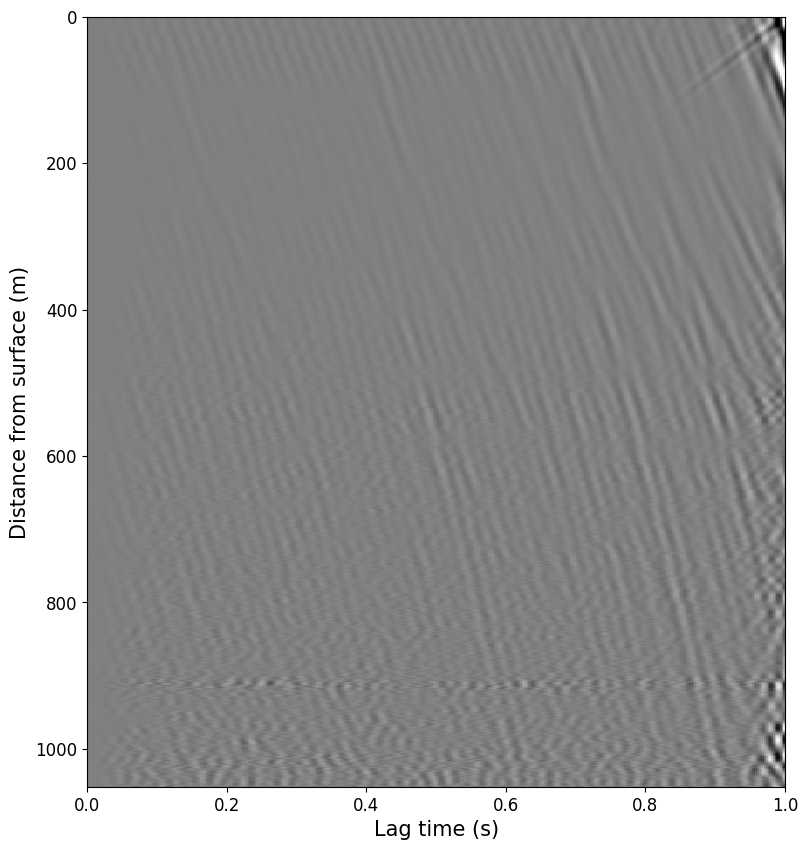

In [12]:
"

Plot stack for surface source

"

# set which leg to plot
# leg = "causal"
leg = "anti"

# plot results
n = chans[end] - (chans[1])
title = string("Stacked correlation functions at ",freqmin,"-",freqmax," Hz (virtual source at surface)")
fname = string("/home/solinger/notebooks/greenlanDAS/paper_figures/misc/surface_corr_anti.png")

# get extent
spacing = (C.misc[4]["shot_point"]-C.misc[3]["shot_point"])/1000
profile_start = 0
profile_end = (chan_end-chan_start) * spacing

# make a plot of the correlations
figure(figsize=(9,10))
extent=[0,maxlag,profile_end,profile_start]
lim = maximum(abs.(C.corr))
zero_lag = Int64(floor(size(C_filt.corr,1)/2))
if leg == "causal"
    imshow(C_filt.corr[zero_lag:end,:]', cmap="gray", interpolation=:none, aspect="auto",extent=extent,vmin=-0.6,vmax=0.6)
else
    imshow(C_filt.corr[1:zero_lag,:]', cmap="gray", interpolation=:none, aspect="auto",extent=extent,vmin=-0.6,vmax=0.6)
end
ylabel("Distance from surface (m)",fontsize=15)
xlabel("Lag time (s)",fontsize=15)
xticks(fontsize=12)
yticks(fontsize=12)
plt.savefig(fname,dpi=200)
#PyPlot.title(title)